In [1]:
import numpy as np
import tensorflow as tf
from keras import layers, models, datasets, utils
from keras.utils import plot_model #type: ignore
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



In [2]:
#Data Preprocessing
##########################################################################

output_folder = 'outputs'


if not os.path.exists(output_folder):
    os.makedirs(output_folder)


hazy_images = os.listdir('hazy')
gt_images = os.listdir('GT')


X = []
Y = []

for filename in hazy_images:
    image_path = os.path.join('hazy', filename)
    
    img = cv2.imread(image_path)
    img = cv2.resize(img, (28, 28))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    img = img / 255.0  # Normalize to [0, 1]
    
    X.append(img)


for filename in gt_images:
    image_path = os.path.join('GT', filename)

    img = cv2.imread(image_path)
    img = cv2.resize(img, (28, 28))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    img = img / 255.0  # Normalize to [0, 1]

    Y.append(img)


# NumPy dizilerine dönüştürme
X = np.array(X)
Y = np.array(Y)


x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [3]:



##########################################################################

# Define the Capsule layer
class CapsuleLayer(layers.Layer):
    def __init__(self, num_capsules, dim_capsules, routings=1, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsules = num_capsules
        self.dim_capsules = dim_capsules
        self.routings = routings

    def build(self, input_shape):
        self.input_num_capsules = input_shape[1]
        self.input_dim_capsules = input_shape[2]

        self.kernel = self.add_weight(name='capsule_kernel',
                                      shape=[self.input_dim_capsules, self.num_capsules * self.dim_capsules],
                                      initializer='glorot_uniform',
                                      trainable=True)

    def call(self, inputs):
        # Compute inputs_hat via einsum
        inputs_hat = tf.einsum('bij, jk->bik', inputs, self.kernel)
        inputs_hat = tf.reshape(inputs_hat, [-1, self.input_num_capsules, self.num_capsules, self.dim_capsules])

        # Routing algorithm
        b = tf.zeros(shape=(tf.shape(inputs_hat)[0], self.input_num_capsules, self.num_capsules))
        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=2)
            s = tf.reduce_sum(c[..., tf.newaxis] * inputs_hat, axis=1)
            v = self.squash(s)
            if i < self.routings - 1:
                b += tf.reduce_sum(inputs_hat * v[:, tf.newaxis, :, :], axis=-1)

        return v

    def squash(self, s, axis=-1):
        s_squared_norm = tf.reduce_sum(tf.square(s), axis, keepdims=True)
        scale = s_squared_norm / (1 + s_squared_norm)
        return scale * s / tf.sqrt(s_squared_norm + tf.keras.backend.epsilon())


# the margin loss function
def margin_loss(y_true, y_pred):
    L = y_true * tf.square(tf.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * tf.square(tf.maximum(0., y_pred - 0.1))
    return tf.reduce_mean(tf.reduce_sum(L, axis=1))


# the reconstruction loss function
def reconstruction_loss(y_true, y_pred):
    from tensorflow.keras import backend as K #type: ignore
    return K.mean(K.square(y_true - y_pred))




In [4]:
# Define the Capsule Network model
from tensorflow.keras.applications import VGG19

input_layer = layers.Input(shape=(28, 28, 3))

conv1 = layers.Conv2D(256, 9, activation='relu')(input_layer)

primary_capsules = layers.Conv2D(256, 9, strides=2, activation='relu')(conv1)
primary_capsules = layers.Reshape([-1, 8])(primary_capsules)

# We have 32 primary capsules (from Conv2D output, 256 filters -> 32*8)
primary_capsules = layers.Lambda(lambda x: tf.reshape(x, [-1, 1152, 8]))(primary_capsules)

digit_capsules = CapsuleLayer(num_capsules=6, dim_capsules=16, routings=1)(primary_capsules)

flat_capsules = layers.Flatten()(digit_capsules)
dense = layers.Dense(96, activation='relu')(flat_capsules)
dense = layers.Dense(512, activation='relu', input_dim=16 * 6)(flat_capsules)
dense = layers.Dense(1024, activation='relu')(dense)


dense = layers.Dense(28 * 28 * 3, activation='sigmoid')(dense)
dense = layers.Reshape(target_shape=(28,28,3))(dense)


model = models.Model(inputs=input_layer, outputs=dense)
model.compile(optimizer='adam', loss=reconstruction_loss)
model.summary()

C:\Users\kemal\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 20, 20, 256)         │          62,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 6, 6, 256)           │       5,308,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 1152, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 1152, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ capsule_layer (CapsuleLayer)         │ (None, 6, 16)               │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │          49,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2352)                │       2,410,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 28, 28, 3)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,357,680 (31.88 MB)

 Trainable params: 8,357,680 (31.88 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
train_data = ([x_train, y_train], y_train)

# Train the model
model.fit(x_train, y_train, batch_size=128, epochs=1000, validation_data=(x_test, y_test))


Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0209 - val_loss: 0.0195
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step - loss: 0.0207 - val_loss: 0.0193
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - loss: 0.0204 - val_loss: 0.0190
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - loss: 0.0201 - val_loss: 0.0188
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - loss: 0.0197 - val_loss: 0.0185
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step - loss: 0.0192 - val_loss: 0.0181
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step - loss: 0.0187 - val_loss: 0.0179
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step - loss: 0.0182 - val_loss: 0.0179
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step - loss: 0.0178 - val_loss: 0.0183
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step - loss: 0.0177 - val_loss: 0.0188
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step - loss: 0.0179 - val_loss: 0.0190
Epoch 12/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step - loss: 0.0174 - val_loss: 0.0179
Epoch 69/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step - loss: 0.0174 - val_loss: 0.0180
Epoch 70/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step - loss: 0.0174 - val_loss: 0.0180
Epoch 71/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step - loss: 0.0174 - val_loss: 0.0180
Epoch 72/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step - loss: 0.0174 - val_loss: 0.0180
Epoch 73/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step - loss: 0.0174 - val_loss: 0.0180
Epoch 74/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step - loss: 0.0174 - val_loss: 0.0180
Epoch 75/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step - loss: 0.0174 - val_loss: 0.0179
Epoch 76/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step - loss: 0.0174 - val_loss: 0.0179
Epoch 77/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step - loss: 0.0174 - val_loss: 0.0179
Epoch 78/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step - loss: 0.0174 - val_loss: 0.0179
Epoch 79/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step - lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - loss: 0.0164 - val_loss: 0.0185
Epoch 136/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - loss: 0.0164 - val_loss: 0.0186
Epoch 137/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - loss: 0.0164 - val_loss: 0.0184
Epoch 138/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - loss: 0.0164 - val_loss: 0.0186
Epoch 139/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - loss: 0.0164 - val_loss: 0.0185
Epoch 140/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - loss: 0.0163 - val_loss: 0.0186
Epoch 141/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - loss: 0.0163 - val_loss: 0.0187
Epoch 142/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - loss: 0.0163 - val_loss: 0.0186
Epoch 143/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step - loss: 0.0162 - val_loss: 0.0189
Epoch 144/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - loss: 0.0162 - val_loss: 0.0185
Epoch 145/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - loss: 0.0164 - val_loss: 0.0190
Epoch 146/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498m

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - loss: 0.0144 - val_loss: 0.0197
Epoch 203/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step - loss: 0.0142 - val_loss: 0.0196
Epoch 204/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - loss: 0.0142 - val_loss: 0.0197
Epoch 205/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - loss: 0.0141 - val_loss: 0.0199
Epoch 206/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - loss: 0.0141 - val_loss: 0.0198
Epoch 207/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - loss: 0.0141 - val_loss: 0.0197
Epoch 208/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - loss: 0.0141 - val_loss: 0.0199
Epoch 209/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - loss: 0.0139 - val_loss: 0.0199
Epoch 210/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - loss: 0.0139 - val_loss: 0.0198
Epoch 211/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - loss: 0.0139 - val_loss: 0.0201
Epoch 212/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - loss: 0.0138 - val_loss: 0.0202
Epoch 213/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474m

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - loss: 0.0124 - val_loss: 0.0214
Epoch 270/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - loss: 0.0121 - val_loss: 0.0217
Epoch 271/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step - loss: 0.0122 - val_loss: 0.0215
Epoch 272/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - loss: 0.0120 - val_loss: 0.0214
Epoch 273/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - loss: 0.0121 - val_loss: 0.0214
Epoch 274/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - loss: 0.0119 - val_loss: 0.0216
Epoch 275/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - loss: 0.0119 - val_loss: 0.0215
Epoch 276/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step - loss: 0.0117 - val_loss: 0.0216
Epoch 277/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - loss: 0.0118 - val_loss: 0.0218
Epoch 278/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - loss: 0.0116 - val_loss: 0.0219
Epoch 279/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - loss: 0.0117 - val_loss: 0.0214
Epoch 280/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484m

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - loss: 0.0090 - val_loss: 0.0231
Epoch 337/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step - loss: 0.0090 - val_loss: 0.0237
Epoch 338/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - loss: 0.0090 - val_loss: 0.0232
Epoch 339/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - loss: 0.0092 - val_loss: 0.0225
Epoch 340/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - loss: 0.0101 - val_loss: 0.0238
Epoch 341/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - loss: 0.0111 - val_loss: 0.0217
Epoch 342/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - loss: 0.0116 - val_loss: 0.0218
Epoch 343/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - loss: 0.0101 - val_loss: 0.0239
Epoch 344/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - loss: 0.0120 - val_loss: 0.0224
Epoch 345/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - loss: 0.0097 - val_loss: 0.0217
Epoch 346/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - loss: 0.0104 - val_loss: 0.0232
Epoch 347/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466m

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - loss: 0.0069 - val_loss: 0.0251
Epoch 404/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - loss: 0.0067 - val_loss: 0.0251
Epoch 405/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - loss: 0.0063 - val_loss: 0.0256
Epoch 406/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - loss: 0.0065 - val_loss: 0.0246
Epoch 407/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - loss: 0.0074 - val_loss: 0.0261
Epoch 408/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - loss: 0.0066 - val_loss: 0.0248
Epoch 409/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - loss: 0.0064 - val_loss: 0.0250
Epoch 410/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step - loss: 0.0061 - val_loss: 0.0264
Epoch 411/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step - loss: 0.0065 - val_loss: 0.0246
Epoch 412/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - loss: 0.0065 - val_loss: 0.0256
Epoch 413/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - loss: 0.0058 - val_loss: 0.0269
Epoch 414/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502m

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - loss: 0.0046 - val_loss: 0.0273
Epoch 471/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - loss: 0.0043 - val_loss: 0.0266
Epoch 472/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - loss: 0.0044 - val_loss: 0.0265
Epoch 473/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step - loss: 0.0042 - val_loss: 0.0272
Epoch 474/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - loss: 0.0042 - val_loss: 0.0273
Epoch 475/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - loss: 0.0042 - val_loss: 0.0269
Epoch 476/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step - loss: 0.0040 - val_loss: 0.0271
Epoch 477/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - loss: 0.0041 - val_loss: 0.0278
Epoch 478/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - loss: 0.0039 - val_loss: 0.0278
Epoch 479/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step - loss: 0.0039 - val_loss: 0.0270
Epoch 480/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - loss: 0.0039 - val_loss: 0.0269
Epoch 481/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481m

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - loss: 0.0024 - val_loss: 0.0293
Epoch 538/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - loss: 0.0023 - val_loss: 0.0294
Epoch 539/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - loss: 0.0023 - val_loss: 0.0295
Epoch 540/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - loss: 0.0023 - val_loss: 0.0291
Epoch 541/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step - loss: 0.0023 - val_loss: 0.0297
Epoch 542/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - loss: 0.0023 - val_loss: 0.0296
Epoch 543/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - loss: 0.0023 - val_loss: 0.0296
Epoch 544/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step - loss: 0.0024 - val_loss: 0.0293
Epoch 545/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step - loss: 0.0026 - val_loss: 0.0300
Epoch 546/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step - loss: 0.0027 - val_loss: 0.0292
Epoch 547/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - loss: 0.0025 - val_loss: 0.0295
Epoch 548/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515m

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step - loss: 0.0016 - val_loss: 0.0306
Epoch 605/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step - loss: 0.0016 - val_loss: 0.0298
Epoch 606/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - loss: 0.0016 - val_loss: 0.0306
Epoch 607/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - loss: 0.0015 - val_loss: 0.0301
Epoch 608/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - loss: 0.0017 - val_loss: 0.0303
Epoch 609/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - loss: 0.0016 - val_loss: 0.0308
Epoch 610/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - loss: 0.0015 - val_loss: 0.0301
Epoch 611/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - loss: 0.0014 - val_loss: 0.0307
Epoch 612/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - loss: 0.0013 - val_loss: 0.0311
Epoch 613/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - loss: 0.0014 - val_loss: 0.0300
Epoch 614/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - loss: 0.0014 - val_loss: 0.0308
Epoch 615/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484m

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - loss: 0.0014 - val_loss: 0.0297
Epoch 672/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step - loss: 0.0012 - val_loss: 0.0297
Epoch 673/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - loss: 0.0011 - val_loss: 0.0298
Epoch 674/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - loss: 0.0011 - val_loss: 0.0301
Epoch 675/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - loss: 0.0011 - val_loss: 0.0292
Epoch 676/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - loss: 0.0012 - val_loss: 0.0296
Epoch 677/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - loss: 0.0011 - val_loss: 0.0294
Epoch 678/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step - loss: 9.9689e-04 - val_loss: 0.0296
Epoch 679/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step - loss: 9.2393e-04 - val_loss: 0.0300
Epoch 680/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step - loss: 9.2860e-04 - val_loss: 0.0296
Epoch 681/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - loss: 0.0010 - val_loss: 0.0300
Epoch 682/1000
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step - loss: 4.6250e-04 - val_loss: 0.0300
Epoch 737/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - loss: 4.3189e-04 - val_loss: 0.0303
Epoch 738/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - loss: 3.8398e-04 - val_loss: 0.0306
Epoch 739/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - loss: 4.1469e-04 - val_loss: 0.0301
Epoch 740/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - loss: 4.5718e-04 - val_loss: 0.0304
Epoch 741/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - loss: 4.0468e-04 - val_loss: 0.0304
Epoch 742/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - loss: 3.8486e-04 - val_loss: 0.0302
Epoch 743/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - loss: 3.9266e-04 - val_loss: 0.0306
Epoch 744/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step - loss: 3.6755e-04 - val_loss: 0.0304
Epoch 745/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - loss: 3.4651e-04 - val_loss: 0.0304
Epoch 746/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - loss: 3.4182e-04 - val_loss: 0.0306
Epo

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step - loss: 0.0012 - val_loss: 0.0295
Epoch 803/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - loss: 9.6098e-04 - val_loss: 0.0295
Epoch 804/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - loss: 0.0011 - val_loss: 0.0300
Epoch 805/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step - loss: 9.5431e-04 - val_loss: 0.0301
Epoch 806/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step - loss: 8.7338e-04 - val_loss: 0.0302
Epoch 807/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - loss: 8.2452e-04 - val_loss: 0.0302
Epoch 808/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step - loss: 8.1368e-04 - val_loss: 0.0299
Epoch 809/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - loss: 7.1408e-04 - val_loss: 0.0298
Epoch 810/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - loss: 7.0770e-04 - val_loss: 0.0299
Epoch 811/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - loss: 6.6363e-04 - val_loss: 0.0299
Epoch 812/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - loss: 6.1171e-04 - val_loss: 0.0301
Epoch 813/1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - loss: 1.5826e-04 - val_loss: 0.0315
Epoch 868/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step - loss: 1.5440e-04 - val_loss: 0.0315
Epoch 869/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - loss: 1.5510e-04 - val_loss: 0.0316
Epoch 870/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - loss: 1.5634e-04 - val_loss: 0.0314
Epoch 871/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - loss: 1.7052e-04 - val_loss: 0.0316
Epoch 872/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - loss: 1.6486e-04 - val_loss: 0.0315
Epoch 873/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - loss: 1.5433e-04 - val_loss: 0.0316
Epoch 874/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - loss: 1.4176e-04 - val_loss: 0.0315
Epoch 875/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step - loss: 1.3974e-04 - val_loss: 0.0315
Epoch 876/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - loss: 1.4327e-04 - val_loss: 0.0316
Epoch 877/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step - loss: 1.4868e-04 - val_loss: 0.0314
Epo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - loss: 7.3754e-05 - val_loss: 0.0318
Epoch 933/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step - loss: 7.8100e-05 - val_loss: 0.0319
Epoch 934/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - loss: 7.6221e-05 - val_loss: 0.0317
Epoch 935/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - loss: 7.0152e-05 - val_loss: 0.0317
Epoch 936/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - loss: 6.8839e-05 - val_loss: 0.0319
Epoch 937/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - loss: 7.1627e-05 - val_loss: 0.0318
Epoch 938/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - loss: 7.1072e-05 - val_loss: 0.0318
Epoch 939/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - loss: 6.5262e-05 - val_loss: 0.0317
Epoch 940/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - loss: 6.8230e-05 - val_loss: 0.0318
Epoch 941/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step - loss: 7.2345e-05 - val_loss: 0.0318
Epoch 942/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - loss: 7.4429e-05 - val_loss: 0.0318
Epo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - loss: 3.0436e-05 - val_loss: 0.0320
Epoch 998/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - loss: 2.9309e-05 - val_loss: 0.0320
Epoch 999/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - loss: 2.9465e-05 - val_loss: 0.0319
Epoch 1000/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - loss: 3.0169e-05 - val_loss: 0.0320


In [6]:
predicted_images = model.predict(x_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


In [7]:
import numpy as np

def check_2d_array_equality(arr):
    # İlk 2D elemanı referans olarak al
    reference_array = arr[0]
    
    # Diğer tüm 2D elemanlarla karşılaştır
    for i in range(1, len(arr)):
        if not np.array_equal(reference_array, arr[i]):
            return False
    
    # Tüm elemanlar aynıysa True döndür
    return True

# 2D elemanların aynı olup olmadığını kontrol et
result = check_2d_array_equality(predicted_images)
print("Tüm 2D elemanlar aynı mı?", result)


Tüm 2D elemanlar aynı mı? False


In [8]:
def lab_to_rgb(lab_images):
    # cv2.COLOR_LAB2RGB ile Lab'den RGB'ye dönüşüm yapılır
    lab_images = (lab_images * 255).astype(np.uint8)
    rgb_images = []
    for lab_image in lab_images:
        # Lab görselini dönüştür

        rgb_image = cv2.cvtColor(lab_image, cv2.COLOR_LAB2RGB)
        rgb_images.append(rgb_image)
    
    return np.array(rgb_images)

In [9]:
predicted_images_normal_rgb = lab_to_rgb(predicted_images)
x_test_normal_rgb = lab_to_rgb(x_test)
y_test_normal_rgb = lab_to_rgb(y_test)

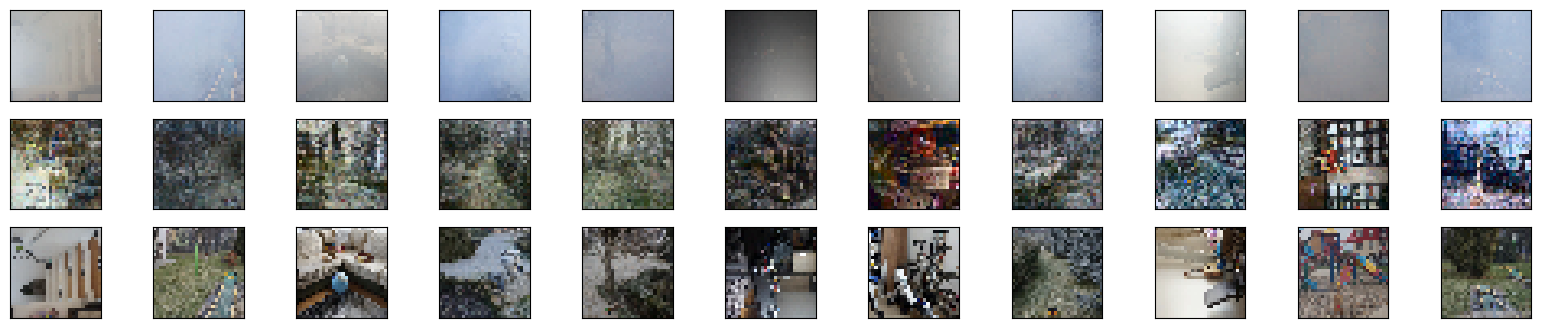

In [10]:
plt.figure(figsize=(20, 4))
for i in range(11):
    # Display original
    ax = plt.subplot(3, 11, i + 1)
    plt.imshow(x_test_normal_rgb[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Display predicted
    ax = plt.subplot(3, 11, i + 1 + 11)
    plt.imshow(predicted_images_normal_rgb[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Display ground truth
    ax = plt.subplot(3, 11, i + 1 + 2*11)
    plt.imshow(y_test_normal_rgb[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [11]:
#model.save("my_cnn_model.h5")
